In [17]:
from IPython.display import Image
from IPython.core.display import HTML 


# Autoencoders

### What are Autoencoders?

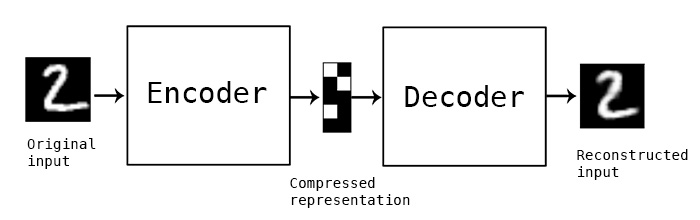

In [16]:
PATH = "/Users/raghu/Downloads/"
Image(filename = PATH + "autoencoder_schema.jpg", width=500, height=500)

"Autoencoding" is a data compression algorithm where the compression and decompression functions are 1) data-specific, 2) lossy, and 3) learned automatically from examples rather than engineered by a human. Additionally, in almost all contexts where the term "autoencoder" is used, the compression and decompression functions are implemented with neural networks.

1) Autoencoders are data-specific, which means that they will only be able to compress data similar to what they have been trained on. This is different from, say, the MPEG-2 Audio Layer III (MP3) compression algorithm, which only holds assumptions about "sound" in general, but not about specific types of sounds. An autoencoder trained on pictures of faces would do a rather poor job of compressing pictures of trees, because the features it would learn would be face-specific.

2) Autoencoders are lossy, which means that the decompressed outputs will be degraded compared to the original inputs (similar to MP3 or JPEG compression). This differs from lossless arithmetic compression.

3) Autoencoders are learned automatically from data examples, which is a useful property: it means that it is easy to train specialized instances of the algorithm that will perform well on a specific type of input. It doesn't require any new engineering, just appropriate training data.

To build an autoencoder, you need three things: an encoding function, a decoding function, and a distance function between the amount of information loss between the compressed representation of your data and the decompressed representation (i.e. a "loss" function). The encoder and decoder will be chosen to be parametric functions (typically neural networks), and to be differentiable with respect to the distance function, so the parameters of the encoding/decoding functions can be optimize to minimize the reconstruction loss, using Stochastic Gradient Descent. It's simple! And you don't even need to understand any of these words to start using autoencoders in practice.

### Are they good at data compression?

Usually, not really. In picture compression for instance, it is pretty difficult to train an autoencoder that does a better job than a basic algorithm like JPEG, and typically the only way it can be achieved is by restricting yourself to a very specific type of picture (e.g. one for which JPEG does not do a good job). The fact that autoencoders are data-specific makes them generally impractical for real-world data compression problems: you can only use them on data that is similar to what they were trained on, and making them more general thus requires lots of training data. 

### What are applications of autoencoders?

They are rarely used in practical applications. In 2012 they briefly found an application in greedy layer-wise pretraining for deep convolutional neural networks, but this quickly fell out of fashion as we started realizing that better random weight initialization schemes were sufficient for training deep networks from scratch. In 2014, batch normalization started allowing for even deeper networks, and from late 2015 we could train arbitrarily deep networks from scratch using residual learning.

Today two interesting practical applications of autoencoders are data denoising (which we feature later in this post), and dimensionality reduction for data visualization. With appropriate dimensionality and sparsity constraints, autoencoders can learn data projections that are more interesting than PCA or other basic techniques.

For 2D visualization specifically, t-SNE (pronounced "tee-snee") is probably the best algorithm around, but it typically requires relatively low-dimensional data. So a good strategy for visualizing similarity relationships in high-dimensional data is to start by using an autoencoder to compress your data into a low-dimensional space (e.g. 32 dimensional), then use t-SNE for mapping the compressed data to a 2D plane. 

### Lets build simplest Autoencoder

In [76]:
from keras.layers import Input, Dense
from keras.models import Model

# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

Let's also create a separate encoder model:

In [77]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

As well as the decoder model:

In [78]:
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

Now let's train our autoencoder to reconstruct MNIST digits.

First, we'll configure our model to use a per-pixel categorical crossentropy loss, and the Adagrad optimizer:

In [79]:
autoencoder.compile(optimizer='adagrad', loss='binary_crossentropy')


Let's prepare our input data. We're using MNIST digits, and we're discarding the labels (since we're only interested in encoding/decoding the input images).

In [80]:
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

We will normalize all values between 0 and 1 and we will flatten the 28x28 images into vectors of size 784.

In [81]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


Now let's train our autoencoder for 100 epochs:

In [67]:
autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=32,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 13s 223us/step - loss: 0.1603 - val_loss: 0.1345
Epoch 2/100
60000/60000 [==============================] - 13s 210us/step - loss: 0.1281 - val_loss: 0.1207
Epoch 3/100
60000/60000 [==============================] - 13s 214us/step - loss: 0.1184 - val_loss: 0.1141
Epoch 4/100
60000/60000 [==============================] - 13s 208us/step - loss: 0.1128 - val_loss: 0.1093
Epoch 5/100
60000/60000 [==============================] - 12s 204us/step - loss: 0.1089 - val_loss: 0.1060
Epoch 6/100
60000/60000 [==============================] - 12s 208us/step - loss: 0.1061 - val_loss: 0.1036
Epoch 7/100
60000/60000 [==============================] - 12s 207us/step - loss: 0.1039 - val_loss: 0.1018
Epoch 8/100
60000/60000 [==============================] - 13s 211us/step - loss: 0.1023 - val_loss: 0.1005
Epoch 9/100
60000/60000 [==============================] - 12s 207us/step - loss: 0.10

Epoch 76/100
60000/60000 [==============================] - 13s 209us/step - loss: 0.0934 - val_loss: 0.0922
Epoch 77/100
60000/60000 [==============================] - 13s 211us/step - loss: 0.0934 - val_loss: 0.0922
Epoch 78/100
60000/60000 [==============================] - 13s 211us/step - loss: 0.0934 - val_loss: 0.0922
Epoch 79/100
60000/60000 [==============================] - 13s 209us/step - loss: 0.0934 - val_loss: 0.0922
Epoch 80/100
60000/60000 [==============================] - 13s 210us/step - loss: 0.0934 - val_loss: 0.0922
Epoch 81/100
60000/60000 [==============================] - 13s 208us/step - loss: 0.0934 - val_loss: 0.0922
Epoch 82/100
60000/60000 [==============================] - 12s 207us/step - loss: 0.0934 - val_loss: 0.0922
Epoch 83/100
60000/60000 [==============================] - 12s 206us/step - loss: 0.0934 - val_loss: 0.0922
Epoch 84/100
60000/60000 [==============================] - 12s 207us/step - loss: 0.0934 - val_loss: 0.0922
Epoch 85/100
60000/

After 100 epochs, the autoencoder seems to reach a stable train/test loss value of about 0.0932. We can try to visualize the reconstructed inputs and the encoded representations. We will use Matplotlib.


In [82]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

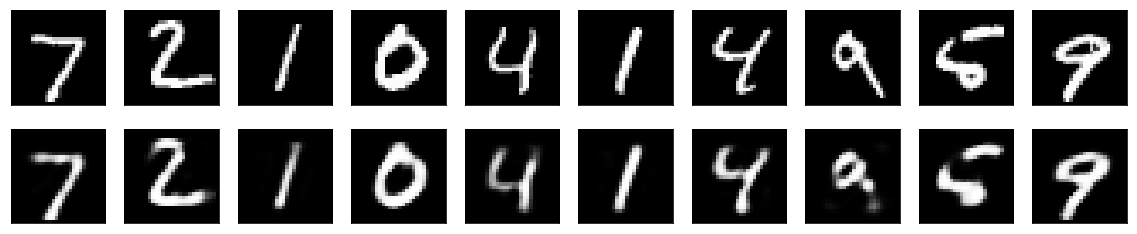

In [69]:
# use Matplotlib 
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Here's what we get. The top row is the original digits, and the bottom row is the reconstructed digits. We are losing quite a bit of detail with this basic approach.

### Adding a sparsity constraint on the encoded representations

In the previous example, the representations were only constrained by the size of the hidden layer (32). In such a situation, what typically happens is that the hidden layer is learning an approximation of PCA (principal component analysis). But another way to constrain the representations to be compact is to add a sparsity contraint on the activity of the hidden representations, so fewer units would "fire" at a given time. In Keras, this can be done by adding an activity_regularizer to our Dense layer:


In [70]:
from keras import regularizers

encoding_dim = 32

input_img = Input(shape=(784,))

# add a Dense layer with a L1 activity regularizer
encoded = Dense(encoding_dim, activation='relu',
                activity_regularizer=regularizers.l1(10e-5))(input_img)
decoded = Dense(784, activation='sigmoid')(encoded)

autoencoder = Model(input_img, decoded)

Let's train this model for 100 epochs (with the added regularization the model is less likely to overfit and can be trained longer).

In [72]:
autoencoder.compile(optimizer='adagrad', loss='binary_crossentropy')
autoencoder.fit(x_train, x_train,
                epochs=250,
                batch_size=25,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/250
60000/60000 [==============================] - 15s 249us/step - loss: 0.1960 - val_loss: 0.1943
Epoch 2/250
60000/60000 [==============================] - 14s 233us/step - loss: 0.1952 - val_loss: 0.1939
Epoch 3/250
60000/60000 [==============================] - 14s 231us/step - loss: 0.1948 - val_loss: 0.1936
Epoch 4/250
60000/60000 [==============================] - 14s 231us/step - loss: 0.1946 - val_loss: 0.1933
Epoch 5/250
60000/60000 [==============================] - 14s 229us/step - loss: 0.1943 - val_loss: 0.1931
Epoch 6/250
60000/60000 [==============================] - 14s 232us/step - loss: 0.1941 - val_loss: 0.1929
Epoch 7/250
60000/60000 [==============================] - 14s 228us/step - loss: 0.1940 - val_loss: 0.1928
Epoch 8/250
60000/60000 [==============================] - 14s 231us/step - loss: 0.1938 - val_loss: 0.1926
Epoch 9/250
60000/60000 [==============================] - 14s 229us/step - loss: 0.19

Epoch 76/250
60000/60000 [==============================] - 14s 231us/step - loss: 0.1906 - val_loss: 0.1895
Epoch 77/250
60000/60000 [==============================] - 14s 234us/step - loss: 0.1906 - val_loss: 0.1895
Epoch 78/250
60000/60000 [==============================] - 14s 230us/step - loss: 0.1906 - val_loss: 0.1895
Epoch 79/250
60000/60000 [==============================] - 14s 231us/step - loss: 0.1906 - val_loss: 0.1894
Epoch 80/250
60000/60000 [==============================] - 14s 233us/step - loss: 0.1906 - val_loss: 0.1894
Epoch 81/250
60000/60000 [==============================] - 14s 229us/step - loss: 0.1905 - val_loss: 0.1894
Epoch 82/250
60000/60000 [==============================] - 14s 229us/step - loss: 0.1905 - val_loss: 0.1894
Epoch 83/250
60000/60000 [==============================] - 14s 228us/step - loss: 0.1905 - val_loss: 0.1894
Epoch 84/250
60000/60000 [==============================] - 14s 228us/step - loss: 0.1905 - val_loss: 0.1893
Epoch 85/250
60000/

60000/60000 [==============================] - 14s 231us/step - loss: 0.1895 - val_loss: 0.1884
Epoch 151/250
60000/60000 [==============================] - 14s 231us/step - loss: 0.1895 - val_loss: 0.1884
Epoch 152/250
60000/60000 [==============================] - 14s 230us/step - loss: 0.1895 - val_loss: 0.1884
Epoch 153/250
60000/60000 [==============================] - 14s 234us/step - loss: 0.1895 - val_loss: 0.1884
Epoch 154/250
60000/60000 [==============================] - 14s 230us/step - loss: 0.1895 - val_loss: 0.1883
Epoch 155/250
60000/60000 [==============================] - 14s 232us/step - loss: 0.1895 - val_loss: 0.1883
Epoch 156/250
60000/60000 [==============================] - 14s 230us/step - loss: 0.1895 - val_loss: 0.1883
Epoch 157/250
60000/60000 [==============================] - 14s 229us/step - loss: 0.1895 - val_loss: 0.1883
Epoch 158/250
60000/60000 [==============================] - 14s 231us/step - loss: 0.1895 - val_loss: 0.1883
Epoch 159/250
60000/6000

60000/60000 [==============================] - 14s 230us/step - loss: 0.1889 - val_loss: 0.1877
Epoch 225/250
60000/60000 [==============================] - 14s 237us/step - loss: 0.1889 - val_loss: 0.1877
Epoch 226/250
60000/60000 [==============================] - 13s 224us/step - loss: 0.1889 - val_loss: 0.1877
Epoch 227/250
60000/60000 [==============================] - 13s 218us/step - loss: 0.1889 - val_loss: 0.1877
Epoch 228/250
60000/60000 [==============================] - 13s 223us/step - loss: 0.1889 - val_loss: 0.1877
Epoch 229/250
60000/60000 [==============================] - 14s 234us/step - loss: 0.1888 - val_loss: 0.1877
Epoch 230/250
60000/60000 [==============================] - 13s 221us/step - loss: 0.1888 - val_loss: 0.1877
Epoch 231/250
60000/60000 [==============================] - 13s 210us/step - loss: 0.1888 - val_loss: 0.1877
Epoch 232/250
60000/60000 [==============================] - 13s 209us/step - loss: 0.1888 - val_loss: 0.1877
Epoch 233/250
60000/6000

The models ends with a train loss of 0.1887 and test loss of 0.876. The difference between the two is mostly due to the regularization term being added to the loss during training (worth about 0.01).

Here's a visualization of our new results:

In [73]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

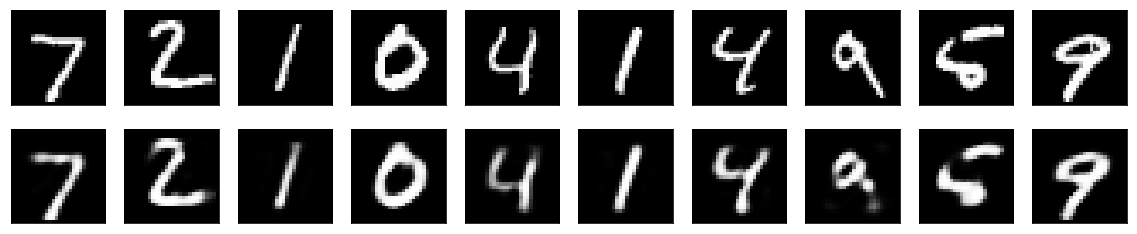

In [74]:
# use Matplotlib 
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Deep autoencoder

We do not have to limit ourselves to a single layer as encoder or decoder, we could instead use a stack of layers, such as:


In [94]:

input_img = Input(shape=(784,))
encoded = Dense(128, activation='relu')(input_img)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)

decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(784, activation='sigmoid')(decoded)

Let's try this:

In [96]:
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=100,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 14s 233us/step - loss: 0.2519 - val_loss: 0.2283
Epoch 2/100
60000/60000 [==============================] - 12s 193us/step - loss: 0.2081 - val_loss: 0.1880
Epoch 3/100
60000/60000 [==============================] - 12s 195us/step - loss: 0.1807 - val_loss: 0.1729
Epoch 4/100
60000/60000 [==============================] - 12s 198us/step - loss: 0.1681 - val_loss: 0.1633
Epoch 5/100
60000/60000 [==============================] - 11s 191us/step - loss: 0.1590 - val_loss: 0.1521
Epoch 6/100
60000/60000 [==============================] - 12s 194us/step - loss: 0.1513 - val_loss: 0.1461
Epoch 7/100
60000/60000 [==============================] - 12s 195us/step - loss: 0.1458 - val_loss: 0.1408
Epoch 8/100
60000/60000 [==============================] - 12s 193us/step - loss: 0.1408 - val_loss: 0.1358
Epoch 9/100
60000/60000 [==============================] - 11s 188us/step - loss: 0.13

Epoch 76/100
60000/60000 [==============================] - 12s 201us/step - loss: 0.0908 - val_loss: 0.0902
Epoch 77/100
60000/60000 [==============================] - 12s 201us/step - loss: 0.0907 - val_loss: 0.0901
Epoch 78/100
60000/60000 [==============================] - 12s 198us/step - loss: 0.0906 - val_loss: 0.0893
Epoch 79/100
60000/60000 [==============================] - 11s 188us/step - loss: 0.0904 - val_loss: 0.0890
Epoch 80/100
60000/60000 [==============================] - 12s 199us/step - loss: 0.0903 - val_loss: 0.0901
Epoch 81/100
60000/60000 [==============================] - 12s 207us/step - loss: 0.0902 - val_loss: 0.0893
Epoch 82/100
60000/60000 [==============================] - 12s 207us/step - loss: 0.0901 - val_loss: 0.0891
Epoch 83/100
60000/60000 [==============================] - 13s 218us/step - loss: 0.0901 - val_loss: 0.0888
Epoch 84/100
60000/60000 [==============================] - 12s 206us/step - loss: 0.0899 - val_loss: 0.0896
Epoch 85/100
60000/

After 100 epochs, it reaches a train and test loss of ~0.0885, a bit better than our previous models.